# Phase 3: Data Preparation

In [534]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from math import radians, cos, sin, asin, sqrt

In [535]:
df= pd.read_csv('datauber.csv')

## 1. Nettoyage des données:

### Les valeurs manquants :

In [538]:
total_missing = df.isnull().sum().sum()
print(f"Nombre total de valeurs manquantes : {total_missing}")

Nombre total de valeurs manquantes : 19922


In [539]:
for col in df.columns:
    percentage_values = df[col].isnull().mean() * 100 
    print(f"{col}: {percentage_values:.2f}%")


Unnamed: 0: 4.81%
key: 5.03%
fare_amount: 4.87%
pickup_datetime: 5.14%
pickup_longitude: 4.94%
pickup_latitude: 5.06%
dropoff_longitude: 4.94%
dropoff_latitude: 5.09%
passenger_count: 5.00%


In [540]:
print("NUMERIC VARIABLES:")
num_var = df._get_numeric_data().columns
for col in num_var:
    print(col)

NUMERIC VARIABLES:
Unnamed: 0
fare_amount
pickup_longitude
pickup_latitude
dropoff_longitude
dropoff_latitude
passenger_count


In [541]:
for col in num_var:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    borne_basse = Q1 - 1.5 * IQR
    borne_haute = Q3 + 1.5 * IQR

    outliers = df[(df[col] < borne_basse) | (df[col] > borne_haute)]
    print(f"Nombre de valeurs extrêmes dans {col} :", outliers.shape[0])

Nombre de valeurs extrêmes dans Unnamed: 0 : 0
Nombre de valeurs extrêmes dans fare_amount : 3545
Nombre de valeurs extrêmes dans pickup_longitude : 2913
Nombre de valeurs extrêmes dans pickup_latitude : 1954
Nombre de valeurs extrêmes dans dropoff_longitude : 3023
Nombre de valeurs extrêmes dans dropoff_latitude : 2563
Nombre de valeurs extrêmes dans passenger_count : 4659


In [542]:
for col in num_var:
    mediane = df[col].median()
    df[col]=df[col].fillna(mediane)
    print(col, df[col].isnull().sum())

Unnamed: 0 0
fare_amount 0
pickup_longitude 0
pickup_latitude 0
dropoff_longitude 0
dropoff_latitude 0
passenger_count 0


In [543]:
print("CATEGORICAL VARIABLES:")
cat_var = df.select_dtypes(include=['object']).columns
for col in cat_var:
    print(col)

CATEGORICAL VARIABLES:
key
pickup_datetime


In [544]:
for col in cat_var:
    mode_val = df[col].mode()[0]
    df[col] = df[col].fillna(mode_val)
    print(col, df[col].isnull().sum())

key 0
pickup_datetime 0


In [545]:
total_missing = df.isnull().sum().sum()
print(f"Nombre total de valeurs manquantes : {total_missing}")

Nombre total de valeurs manquantes : 0


### Supprission de la colonne unnamed :

In [547]:
df = df.drop(columns=["Unnamed: 0"])

### Suppression des cordonnées GPS invalides :

In [549]:
df = df[~((df['pickup_longitude'] == 0) & (df['pickup_latitude'] == 0))]
df = df[~((df['dropoff_longitude'] == 0) & (df['dropoff_latitude'] == 0))]

In [550]:
outliers_pickup = df[(df['pickup_longitude'] < -180) | (df['pickup_longitude'] > 180)]
outliers_dropoff = df[(df['dropoff_longitude'] < -180) | (df['dropoff_longitude'] > 180)]
print("Pickup longitude hors bornes :", len(outliers_pickup))
print("Dropoff longitude hors bornes :", len(outliers_dropoff))

Pickup longitude hors bornes : 1
Dropoff longitude hors bornes : 1


In [551]:
outliers_pickup = df[(df['pickup_latitude'] < -90) | (df['pickup_latitude'] > 90)]
outliers_dropoff = df[(df['dropoff_latitude'] < -90) | (df['dropoff_latitude'] > 90)]
print("Pickup latitude hors bornes :", len(outliers_pickup))
print("Dropoff latitude hors bornes :", len(outliers_dropoff))

Pickup latitude hors bornes : 0
Dropoff latitude hors bornes : 0


In [552]:
df = df[(df['pickup_longitude'].between(-180, 180)) &
        (df['dropoff_longitude'].between(-180, 180))]

### Vérification de la colonne Passenger_Count :

In [554]:
outliers_passenger0 = df[ df['passenger_count'] == 0]
outliers_passenger6 = df[(df['passenger_count'] > 6) ]
print("nombre de passager null:", len(outliers_passenger0))
print("nombre de passager plus que 6:", len(outliers_passenger6))

nombre de passager null: 131
nombre de passager plus que 6: 0


In [555]:
df = df[~(df['passenger_count'] == 0)]

##### key peut être duppliqué puisqu'il est composé de date et temps 
#### Suppression des doublons exacts (mêmes valeurs dans toutes les colonnes)

In [557]:
df = df.drop_duplicates()

### Correction des Prix aberrants :

##### On supprime les prix aberrantes à partir de 130 

In [560]:
df = df[~(df['fare_amount'] >= 130)]

## Feature engineering
### change latitude and longitude to distance

### change pickup_datetime to hours and days columns

In [563]:
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    km = 6371 * c
    return km

In [564]:
df['distance_km'] = df.apply(lambda row: haversine(
    row['pickup_longitude'], row['pickup_latitude'],
    row['dropoff_longitude'], row['dropoff_latitude']), axis=1)

In [565]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce')

In [566]:
df['pickup_hour'] = df['pickup_datetime'].dt.hour
df['pickup_dow'] = df['pickup_datetime'].dt.dayofweek  
df['is_weekend'] = df['pickup_dow'].isin([5,6]).astype(int)

In [567]:
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_km,pickup_hour,pickup_dow,is_weekend
0,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1.0,1.683323,19,3,0
1,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1.0,2.457590,20,4,0
2,2009-08-24 21:45:00.00000061,12.9,2009-01-11 13:07:00+00:00,-74.005043,40.740770,-73.980170,40.772647,1.0,4.117407,13,6,1
3,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.752503,-73.965316,40.803349,3.0,5.726622,8,4,0
4,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00+00:00,-73.981857,40.744085,-73.973082,40.752910,5.0,1.228574,17,3,0


### verification de la colonne distance_km

In [569]:
df[(df['distance_km']==0) & (df['pickup_longitude'] != df['dropoff_longitude']) & (df['pickup_latitude'] != df['pickup_latitude'])]

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_km,pickup_hour,pickup_dow,is_weekend


## supprimer les valeurs abberantes dans la colonne distance_km

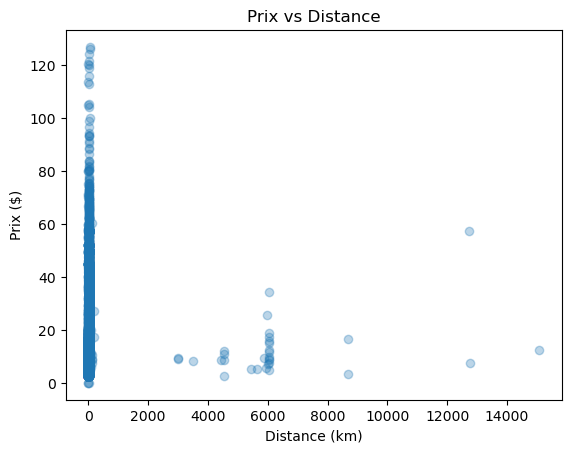

In [571]:
import matplotlib.pyplot as plt

plt.scatter(df['distance_km'], df['fare_amount'], alpha=0.3)
plt.xlabel('Distance (km)')
plt.ylabel('Prix ($)')
plt.title('Prix vs Distance')
plt.show()

In [572]:
df= df[df['distance_km']<100]

In [573]:
df.shape

(43266, 12)

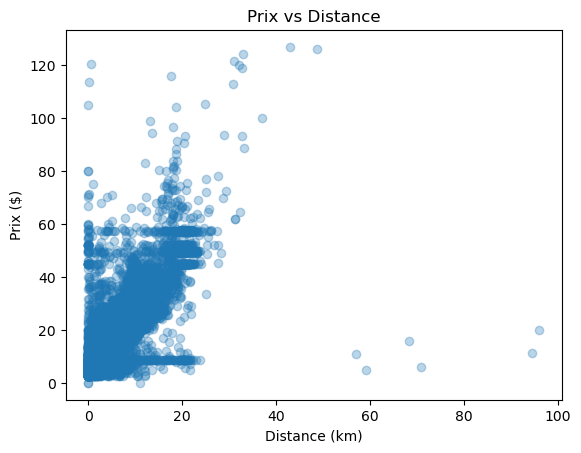

In [574]:
import matplotlib.pyplot as plt

plt.scatter(df['distance_km'], df['fare_amount'], alpha=0.3)
plt.xlabel('Distance (km)')
plt.ylabel('Prix ($)')
plt.title('Prix vs Distance')
plt.show()

## Vérifier si ces trajets sont plausibles économiquement :

In [576]:
import numpy as np

df['price_per_km'] = np.where(
    df['distance_km'] < 1,
    df['fare_amount'],                          # if distance < 0.1
    df['fare_amount'] / df['distance_km']       # else
)
print(df['price_per_km'].describe()) 

count    43266.000000
mean         4.171989
std          2.960360
min          0.000000
25%          2.886786
50%          3.707200
75%          4.746613
max        120.300000
Name: price_per_km, dtype: float64


In [577]:
df[df['price_per_km']==0]

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_km,pickup_hour,pickup_dow,is_weekend,price_per_km
20744,2015-04-22 23:25:07.0000008,0.0,2015-04-22 23:25:07+00:00,-73.658897,40.805199,-73.658897,40.805199,1.0,0.000000,23,2,0,0.0
22182,2010-03-20 02:59:51.0000002,0.0,2010-03-20 02:59:51+00:00,-73.994366,40.755395,-73.998718,40.854853,2.0,11.065289,2,5,1,0.0


In [578]:
df[(df['distance_km']<50) & (df['fare_amount']>90)]

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_km,pickup_hour,pickup_dow,is_weekend,price_per_km
880,2013-06-18 15:41:55.0000002,93.16,2013-06-18 15:41:55+00:00,-73.777117,40.645058,-74.155763,40.579618,2.0,32.779903,15,1,0,2.841985
2053,2014-11-01 08:42:39.0000002,113.66,2014-11-01 08:42:39+00:00,-73.951227,40.778753,-73.949938,40.778149,1.0,0.127635,8,5,1,113.660000
4364,2012-09-12 13:09:20.0000001,93.30,2012-09-12 13:09:20+00:00,-73.991668,40.749564,-73.790275,40.643787,2.0,20.654484,13,2,0,4.517179
5968,2011-05-06 00:40:00.000000224,105.00,2011-05-06 00:40:00+00:00,-73.752265,40.923303,-73.752270,40.923303,1.0,0.000420,0,4,0,105.000000
9060,2011-06-13 15:46:00.00000036,126.10,2011-06-13 15:46:00+00:00,-73.788657,40.640643,-74.001350,41.048048,1.0,48.706330,15,0,0,2.588986
11301,2013-12-06 02:17:00.00000053,113.00,2013-12-06 02:17:00+00:00,-74.468770,40.476630,-74.468772,40.752910,2.0,30.720934,2,4,0,3.678274
15362,2009-01-18 01:03:55.0000002,120.30,2011-06-02 15:17:13+00:00,-73.995309,40.769470,-73.988705,40.768919,2.0,0.559508,15,3,0,120.300000
15461,2015-03-17 02:33:09.0000002,120.08,2015-03-17 02:33:09+00:00,-73.954262,40.673717,-74.165054,40.913963,2.0,32.070607,2,1,0,3.744238
17183,2014-01-21 14:22:00.00000059,96.50,2014-01-21 14:22:00+00:00,-73.976660,40.752503,-74.177077,40.694952,1.0,18.060979,14,1,0,5.343010
20928,2013-03-19 14:39:00.00000099,90.75,2013-03-19 14:39:00+00:00,-73.981857,40.801920,-74.176798,40.694337,1.0,20.316976,14,1,0,4.466708


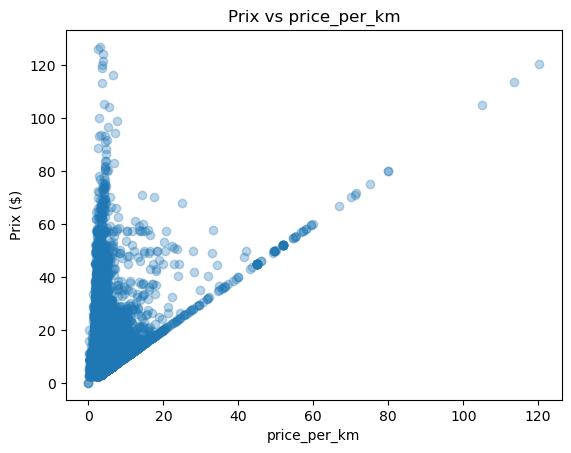

In [579]:
plt.scatter(df['price_per_km'], df['fare_amount'], alpha=0.3)
plt.xlabel('price_per_km')
plt.ylabel('Prix ($)')
plt.title('Prix vs price_per_km')
plt.show()

In [580]:
df[df['price_per_km']>10]

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_km,pickup_hour,pickup_dow,is_weekend,price_per_km
4,2014-08-28 17:47:00.000000188,16.00,2014-08-28 17:47:00+00:00,-73.981857,40.744085,-73.973082,40.752910,5.0,1.228574,17,3,0,13.023229
40,2010-04-01 14:42:00.000000160,15.70,2010-04-01 14:42:00+00:00,-73.973360,40.752503,-73.972810,40.743548,1.0,0.996797,14,3,0,15.700000
54,2009-04-09 11:27:00.000000125,16.90,2009-04-09 11:27:00+00:00,-73.986593,40.759143,-74.001767,40.752910,1.0,1.453927,11,3,0,11.623696
64,2014-08-22 14:58:01.0000001,13.00,2014-08-22 14:58:01+00:00,-73.993619,40.749808,-73.992512,40.756546,2.0,0.755012,14,4,0,13.000000
84,2009-08-07 10:43:07.0000001,49.57,2009-08-07 10:43:07+00:00,-73.975058,40.752503,-73.980170,40.788820,1.0,4.061178,10,4,0,12.205819
...,...,...,...,...,...,...,...,...,...,...,...,...,...
44052,2013-08-13 11:15:00.00000092,10.50,2013-08-13 11:15:00+00:00,-73.984972,40.759190,-73.983535,40.750902,4.0,0.929498,11,1,0,10.500000
44075,2009-05-23 19:15:00.000000150,13.70,2009-05-23 19:15:00+00:00,-73.997388,40.752503,-73.990317,40.757333,1.0,0.802008,19,5,1,13.700000
44131,2010-09-16 07:17:10.0000001,11.30,2010-09-16 07:17:10+00:00,-73.975982,40.752503,-73.987515,40.752910,1.0,0.972525,7,3,0,11.300000
44154,2011-07-29 21:33:44.0000001,12.50,2011-07-29 21:33:44+00:00,-73.981857,40.763648,-73.985091,40.752910,4.0,1.224682,21,4,0,10.206735


In [581]:
df=df[df['price_per_km']<10]

In [582]:
df.shape

(42508, 13)

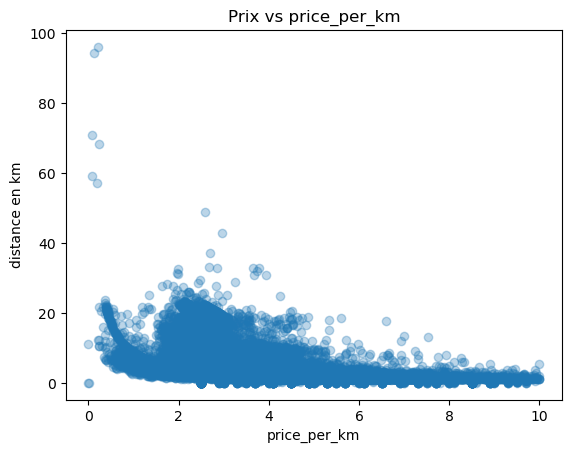

In [636]:
plt.scatter(df['price_per_km'], df['distance_km'], alpha=0.3)
plt.xlabel('price_per_km')
plt.ylabel('distance en km')
plt.title('Prix vs price_per_km')
plt.show()

In [638]:
df[((df['distance_km'] > 20) & (df['fare_amount'] < 5))]

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_km,pickup_hour,pickup_dow,is_weekend,price_per_km


In [640]:
df[((df['distance_km'] < 1) & (df['fare_amount'] > 100))]

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_km,pickup_hour,pickup_dow,is_weekend,price_per_km


In [642]:
df[((df['distance_km'] < 1) & (df['fare_amount'] > 100))]

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_km,pickup_hour,pickup_dow,is_weekend,price_per_km


In [644]:
df['passenger_count'] = df['passenger_count'].astype(int)

In [632]:
df.to_csv(r"C:\Users\hanin\OneDrive\Desktop\Hanine Attia\projects\projet uber ML (CRISP-DM)/database_clean.csv", index=False)

In [646]:
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_km,pickup_hour,pickup_dow,is_weekend,price_per_km
0,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1,1.683323,19,3,0,4.455474
1,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1,2.457590,20,4,0,3.133151
2,2009-08-24 21:45:00.00000061,12.9,2009-01-11 13:07:00+00:00,-74.005043,40.740770,-73.980170,40.772647,1,4.117407,13,6,1,3.133040
3,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.752503,-73.965316,40.803349,3,5.726622,8,4,0,0.925502
5,2011-02-12 02:27:09.0000006,4.9,2011-02-12 02:27:09+00:00,-73.969019,40.755910,-73.969019,40.755910,1,0.000000,2,5,1,4.900000
